## FLAML for hp optimisation and model selection
We use FLAML twice, first to find the best component model for each estimator, and then to optimise the estimators themselves and choose the best estimator. Here we show how it's done

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import warnings
warnings.filterwarnings('ignore') # suppress sklearn deprecation warnings for now.. 

# the below checks for whether we run dowhy and auto-causality from source
root_path = root_path = os.path.realpath('../..')
try: 
    import auto_causality
except ModuleNotFoundError:
    print("Running auto-causality from local source")
    sys.path.append(os.path.join(root_path, "auto-causality"))
    
try:
    import dowhy
except ModuleNotFoundError:
    print("Running dowhy from local source")
    sys.path.append(os.path.join(root_path, "dowhy"))

Running auto-causality from local source
Running dowhy from local source


In [2]:
from auto_causality import AutoCausality
from auto_causality.datasets import synth_ihdp, preprocess_dataset
from auto_causality.scoring import ate

### Model fitting & scoring
Here we fit a (selection of) model(s) to the data and score them with the ERUPT metric on held-out data

In [3]:
# import dataset
data_df = synth_ihdp()
data_df, features_X, features_W, targets, treatment = preprocess_dataset(data_df)
outcome = targets[0]

# choose which estimators to fit
estimator_list =["CausalForestDML"] #["LinearDML","SLearner","TransformedOutcome", "ForestDRLearner"]

# init autocausality object with chosen metric to optimise
ac = AutoCausality(
    time_budget=180, 
    estimator_list=estimator_list, 
    metric="erupt", 
    verbose=3,
    components_verbose=2,
    components_time_budget=30,
    use_ray=False
)

# run autocausality
myresults = ac.fit(data_df, treatment, outcome, features_W, features_X)

# return best estimator
print(f"Best estimator: {ac.best_estimator}")
# config of best estimator:
print(f"best config: {ac.best_config}")
# best score:
print(f"best score: {ac.best_score}")


[flaml.automl: 03-14 16:25:12] {2145} WARNING - Time taken to find the best model is 86% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.
[flaml.tune.tune: 03-14 16:25:42] {326} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 03-14 16:25:42] {447} INFO - trial 1 config: {'mc_iters': 7, 'drate': 0, 'n_estimators': 486, 'criterion': 'mse', 'max_depth': 607, 'min_samples_split': 44, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.1402651224893096, 'min_var_fraction_leaf': 0.9786126288372129, 'max_features': 'auto', 'min_impurity_decrease': 8.455853101737429, 'max_samples': 0.5325230542389162, 'min_balancedness_tol': 0.3181108401277295, 'honest': 0, 'fit_intercept': 0, 'subforest_size': 3}
[flaml.tune.tune: 03-14 16:33:29] {108} INFO - result: {'erupt': 6.710547847132527, 'qini': 0.028483353540614806, 'auc': 0.4910728895647998, 'ate': 3.7479790947683487, '

... Estimator: backdoor.econml.dml.CausalForestDML
 erupt (validation): 6.710548
 qini (validation): 0.028483
 auc (validation): 0.491073
 ate (validation): 3.747979
 r_score (validation): -0.001190
Best estimator: backdoor.econml.dml.CausalForestDML
best config: {'mc_iters': 7, 'drate': 0, 'n_estimators': 486, 'criterion': 'mse', 'max_depth': 607, 'min_samples_split': 44, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.1402651224893096, 'min_var_fraction_leaf': 0.9786126288372129, 'max_features': 'auto', 'min_impurity_decrease': 8.455853101737429, 'max_samples': 0.5325230542389162, 'min_balancedness_tol': 0.3181108401277295, 'honest': 0, 'fit_intercept': 0, 'subforest_size': 3}
best score: 6.710547847132527


In [4]:
outcome = targets[0]
ac.full_scores["baseline"]={"estimator": "baseline",
                               "outcome": outcome,
                              "train":{"erupt": ac.train_df[outcome].mean(),
                                       "ate": ate(ac.train_df[treatment],ac.train_df[outcome])[0]},
                              "validation":{"erupt": ac.test_df[outcome].mean(),
                                      "ate": ate(ac.test_df[treatment],ac.test_df[outcome])[0]}}

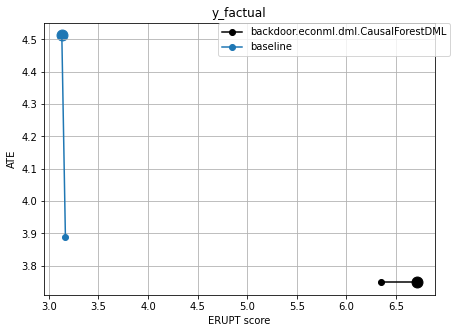

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

colors = ([matplotlib.colors.CSS4_COLORS['black']] +
    list(matplotlib.colors.TABLEAU_COLORS) + [
    matplotlib.colors.CSS4_COLORS['lime'],
    matplotlib.colors.CSS4_COLORS['yellow'],
    matplotlib.colors.CSS4_COLORS['pink']
])

v = ac.full_scores
plt.figure(figsize = (7,5))
plt.title(outcome)
for (est, scr),col in zip(v.items(),colors):
    sc = [scr['train']['erupt'], scr['validation']['erupt']]
    crv = [scr['train']['ate'], scr['validation']['ate']]
    plt.plot(sc, crv, color=col, marker="o")
    plt.scatter(sc[1:],crv[1:], c=col, s=120 )
    plt.grid()
    plt.xlabel("ERUPT score")
    plt.ylabel("ATE")
    plt.legend(v.keys(),bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.grid()
plt.show()


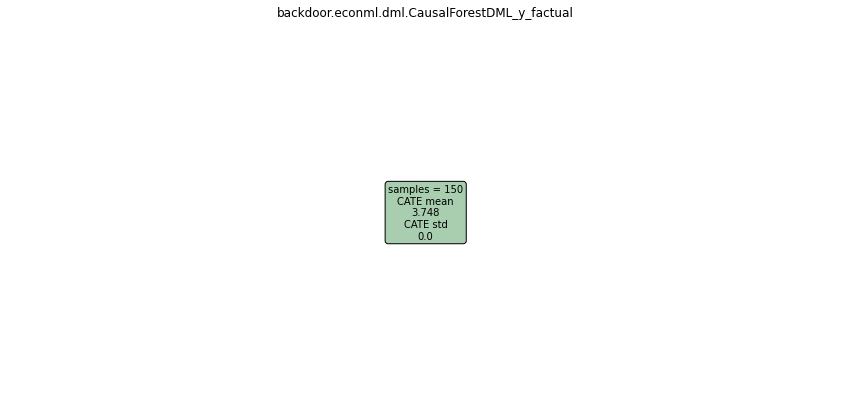

In [6]:
scr = ac.full_scores[ac.best_estimator]
intrp = scr['validation']['intrp']
plt.figure(figsize=(15, 7))
try: 
    feature_names = intrp.feature_names
except:
    feature_names = features_X + [ w for w in features_W if w not in features_X]
intrp.plot(feature_names=intrp.feature_names, fontsize=10)
#         intrp.plot( fontsize=10)
plt.title(f"{ac.best_estimator}_{outcome}")
plt.show()


y_factual backdoor.econml.dml.CausalForestDML



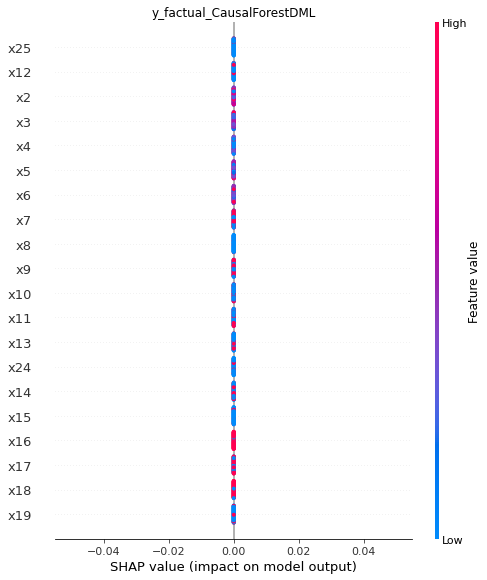

In [7]:
# TODO: add SHAP plots!
import matplotlib.pyplot as plt
import shap

# and now let's visualize feature importances!
from auto_causality.shap import shap_values

# Shapley values calculation can be slow so let's subsample
this_df = ac.test_df.sample(100)

wanted = ["CausalForestDML"]#,"ForestDRLearner","DirectUpliftDoWhyWrapper"]#,"CausalForestDML",]

scr = ac.full_scores[ac.best_estimator]
print(outcome, ac.best_estimator)
est = ac.estimates[ac.best_estimator]
shaps = shap_values(est, this_df)

plt.title(outcome + '_' + ac.best_estimator.split('.')[-1])
shap.summary_plot(shaps, this_df[est.estimator._effect_modifier_names])
plt.show()
